６０．データの入手・整形

In [3]:
! wget -O ./data/SST-2.zip https://dl.fbaipublicfiles.com/glue/data/SST-2.zip 
! unzip -d ./data ./data/SST-2.zip

--2025-05-14 18:33:43--  https://dl.fbaipublicfiles.com/glue/data/SST-2.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.224.57, 3.163.224.86, 3.163.224.94, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.224.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7439277 (7.1M) [application/zip]
Saving to: ‘./data/SST-2.zip’

./data/SST-2.zip    100%[===================>]   7.09M  46.9MB/s    in 0.2s    

2025-05-14 18:33:44 (46.9 MB/s) - ‘./data/SST-2.zip’ saved [7439277/7439277]

Archive:  ./data/SST-2.zip
   creating: ./data/SST-2/
  inflating: ./data/SST-2/dev.tsv    
   creating: ./data/SST-2/original/
  inflating: ./data/SST-2/original/README.txt  
  inflating: ./data/SST-2/original/SOStr.txt  
  inflating: ./data/SST-2/original/STree.txt  
  inflating: ./data/SST-2/original/datasetSentences.txt  
  inflating: ./data/SST-2/original/datasetSplit.txt  
  inflating: ./data/SST-2/original/dictionary.txt  
  inflating

In [5]:
import pandas as pd
from pandas import DataFrame
import numpy as np

train_path = "./data/SST-2/train.tsv"
dev_path = "./data/SST-2/dev.tsv"
test_path = "./data/SST-2/test.tsv"

df_train = pd.read_csv(train_path, sep="\t")
df_dev = pd.read_csv(dev_path, sep="\t")
df_test = pd.read_csv(test_path, sep="\t")

df_train.head()

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0


In [6]:
def countPosNeg(df:DataFrame)->tuple[int, int]:
    size = df.groupby("label").size()
    num_pos = size[1]
    num_neg = size[0]
    return (num_pos, num_neg)

num_pos, num_neg = countPosNeg(df_train)
print(f'Train\tpositive: {num_pos}, negative: {num_neg}')
num_pos, num_neg = countPosNeg(df_dev)
print(f'Dev\tpositive: {num_pos:5d}, negative: {num_neg:5d}')

Train	positive: 37569, negative: 29780
Dev	positive:   444, negative:   428


６１．特徴ベクトル

In [7]:
import csv
from collections import Counter

def load_data_with_features(filepath):
    data = []
    with open(filepath, encoding='utf-8') as f:
        reader = csv.DictReader(f, delimiter='\t') #ヘッダー付きTSVファイルとして読み込み
        for row in reader:
            text = row['sentence'].strip()
            label = row['label'].strip()
            tokens = text.split() #スペースでトークン化
            feature = dict(Counter(tokens)) #単語の出現頻度カウント
            instance = {'text': text, 'label': label, 'feature': feature}
            data.append(instance)
    return data

#学習データと検証データを読み込み
train_data = load_data_with_features(train_path)
dev_data = load_data_with_features(dev_path)

#学習データの最初の事例を表示
print("学習データの最初の事例:")
print(train_data[0])

学習データの最初の事例:
{'text': 'hide new secretions from the parental units', 'label': '0', 'feature': {'hide': 1, 'new': 1, 'secretions': 1, 'from': 1, 'the': 1, 'parental': 1, 'units': 1}}


６２．学習

In [8]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#特徴とラベルの抽出
def extract_features_and_labels(data):
    X = [instance['feature'] for instance in data] #特徴ベクトル（辞書）
    y = [int(instance['label']) for instance in data] #ラベル（整数化）
    return X, y

#特徴とラベルを抽出
X_train_dict , y_train = extract_features_and_labels(train_data)
X_dev_dict, y_dev = extract_features_and_labels(dev_data)

#辞書->数値ベクトルに変換
vectorizer = DictVectorizer(sparse=True)
X_train = vectorizer.fit_transform(X_train_dict)
X_dev = vectorizer.transform(X_dev_dict)

#ロジスティック回帰モデルの学習
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

#予測と評価
y_pred = clf.predict(X_dev)
accuracy = accuracy_score(y_dev, y_pred)

print ("検証データにおける正解率:", accuracy)

検証データにおける正解率: 0.8096330275229358


６３．予測

In [9]:
# 検証データの先頭の事例を取り出す
first_dev_instance = dev_data[0]
trie_label = int(first_dev_instance['label']) #正解ラベル
feature_dict = first_dev_instance['feature'] #BoW辞書特徴量

#ベクトルに変換
X_first = vectorizer.transform([feature_dict]) #１件でもリストで包む

#ラベルを予感
predicted_label = clf.predict(X_first)[0] #予測ラベル（整数）

#結果表示
print("検証データの先頭の事例:")
print("テキスト:", first_dev_instance['text'])
print("正解ラベル:", trie_label)
print("予測ラベル:", predicted_label)

検証データの先頭の事例:
テキスト: it 's a charming and often affecting journey .
正解ラベル: 1
予測ラベル: 1


６４．条件付き確率

In [10]:
# 検証データの先頭の事例を取り出す
first_dev_instance = dev_data[0]
feature_dict = first_dev_instance['feature'] # BoW特徴量辞書

# 特徴をベクトルに変換
X_first = vectorizer.transform([feature_dict])

# 条件付き確率の予測
proba = clf.predict_proba(X_first)[0] # クラスごとの確率（配列）

# ラベルの順序を取得（例[0,1]）
label_order = clf.classes_

# 出力
print("検証データの先頭の事例の条件付き確率")
for label, p in zip(label_order, proba):
    label_name = "ポジティブ" if label == 1 else "ネガティブ"
    print(f"ラベル{label} ({label_name}) : {p:.4f}")

検証データの先頭の事例の条件付き確率
ラベル0 (ネガティブ) : 0.0043
ラベル1 (ポジティブ) : 0.9957


６５．テキストのポジネガの予測

In [12]:
def predict_sentiment(text):
    # 前処理：トークン化（スペース区切り）
    tokens = text.strip().split()
    feature_dict = dict(Counter(tokens))

    # BoWベクトルに変換
    X = vectorizer.transform([feature_dict])

    # ラベル予測
    predicted_label = clf.predict(X)[0]
    predicted_proba = clf.predict_proba(X)[0]

    # 出力
    label_name = "ポジティブ" if predicted_label == 1 else "ネガティブ"
    print(f"テキスト： {text}")
    print(f"予測ラベル： {predicted_label} ({label_name})")
    print(f"確率： ネガティブ={predicted_proba[0]:.4f}, ポジティブ={predicted_proba[1]:.4f}")

# テストテキストで実行
sample_text = "the worst movie I 've ever seen"
predict_sentiment(sample_text)

テキスト： the worst movie I 've ever seen
予測ラベル： 0 (ネガティブ)
確率： ネガティブ=0.9774, ポジティブ=0.0226


６６．混合行列の作成

In [14]:
from sklearn.metrics import confusion_matrix

# 検証データ全体に対する予測
y_pred = clf.predict(X_dev)

# 混同行列の計算
cm = confusion_matrix(y_dev, y_pred, labels=[0, 1])

# 結果表示
print("混同行列:")
print("        予測:ネガティブ  予測:ポジティブ")
print(f"実際:ネガティブ    {cm[0][0]}              {cm[0][1]}")
print(f"実際:ポジティブ    {cm[1][0]}              {cm[1][1]}")

混同行列:
        予測:ネガティブ  予測:ポジティブ
実際:ネガティブ    334              94
実際:ポジティブ    72              372


６７．精度の計測

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(X, y_true, dataset_name="データ"):
    y_pred = clf.predict(X)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="binary")
    rec = recall_score(y_true, y_pred, average="binary")
    f1 = f1_score(y_true, y_pred, average="binary")

    print(f"\n[{dataset_name}]")
    print(f"正解率 (Accuracy)      : {acc:.4f}")
    print(f"適合率 (Precision)     : {prec:.4f}")
    print(f"再現率 (Recall)        : {rec:.4f}")
    print(f"F1スコア               : {f1:.4f}")

# 学習データで評価
evaluate_model(X_train, y_train, dataset_name="学習データ")

# 検証データで評価
evaluate_model(X_dev, y_dev, dataset_name="検証データ")



[学習データ]
正解率 (Accuracy)      : 0.9424
適合率 (Precision)     : 0.9431
再現率 (Recall)        : 0.9544
F1スコア               : 0.9487

[検証データ]
正解率 (Accuracy)      : 0.8096
適合率 (Precision)     : 0.7983
再現率 (Recall)        : 0.8378
F1スコア               : 0.8176


６８．特徴量の重みの確認

In [16]:
import numpy as np

# 特徴量名（単語）を取得
feature_names = vectorizer.get_feature_names_out()

# ロジスティック回帰モデルの重み（クラス1＝ポジティブに対応する係数）
coefficients = clf.coef_[0]

# 単語と重みのペアを作成
feature_weights = list(zip(feature_names, coefficients))

# 重みでソート（降順：ポジティブ寄り）
top_positive = sorted(feature_weights, key=lambda x: x[1], reverse=True)[:20]

# 重みでソート（昇順：ネガティブ寄り）
top_negative = sorted(feature_weights, key=lambda x: x[1])[:20]

# 表示
print("ポジティブ寄りの特徴量（重みが大きい）トップ２０：")
for word, weight in top_positive:
    print(f"{word:20s} {weight:.4f}")

print("\nネガティブ寄りの特徴量（重みが小さい）トップ20：")
for word, weights in top_negative:
    print(f"{word:20s} {weight:.4f}")
    

ポジティブ寄りの特徴量（重みが大きい）トップ２０：
refreshing           3.4332
remarkable           3.4280
powerful             3.2230
hilarious            3.1823
beautiful            3.0012
wonderful            2.9737
prose                2.9279
terrific             2.8732
appealing            2.8571
enjoyable            2.8165
treat                2.8034
charmer              2.7524
vividly              2.7156
likable              2.6930
solid                2.6522
charming             2.6208
half-bad             2.6180
fascinating          2.6138
impressive           2.5980
intriguing           2.5649

ネガティブ寄りの特徴量（重みが小さい）トップ20：
lacking              2.5649
lacks                2.5649
worst                2.5649
devoid               2.5649
mess                 2.5649
failure              2.5649
stupid               2.5649
bore                 2.5649
flat                 2.5649
depressing           2.5649
loses                2.5649
waste                2.5649
lack                 2.5649
squanders            2.

６９．正則化パラメータの変更

C=0.0010 -> 検証正解率=0.6846
C=0.0036 -> 検証正解率=0.7156
C=0.0129 -> 検証正解率=0.7661
C=0.0464 -> 検証正解率=0.8028
C=0.1668 -> 検証正解率=0.8085
C=0.5995 -> 検証正解率=0.8050
C=2.1544 -> 検証正解率=0.8177
C=7.7426 -> 検証正解率=0.8211
C=27.8256 -> 検証正解率=0.8108
C=100.0000 -> 検証正解率=0.7947


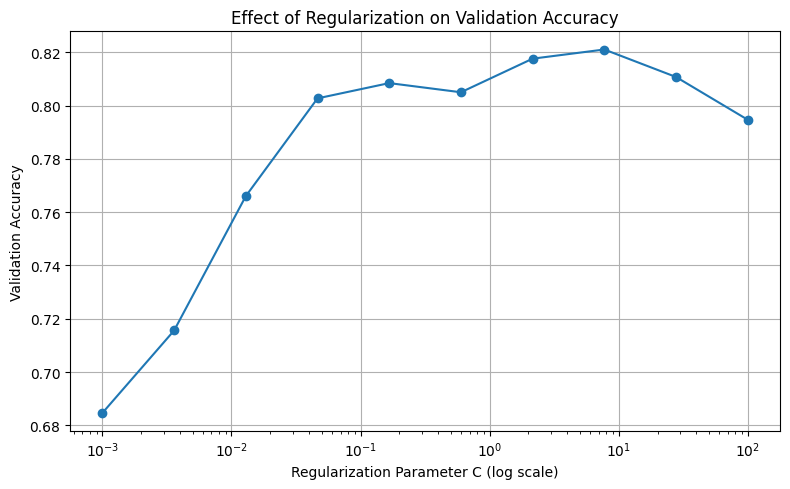

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 試す正則化パラメータ（c: 大きいほど正則化が弱い）
C_values = np.logspace(-3, 2, 10) # 0.001 ~ 100 の対数スケール

# 各パラメータでの正解率を格納
dev_accuracies = []

for C in C_values:
    # ロジスティック回帰モデルを学習
    model = LogisticRegression(C=C, solver="liblinear") # BoWベクトルに最適なシンプルなソルバー
    model.fit(X_train, y_train)

    # 検証データで予測して正解率を計算
    y_dev_pred = model.predict(X_dev)
    acc = accuracy_score(y_dev, y_dev_pred)
    dev_accuracies.append(acc)

    print(f"C={C:.4f} -> 検証正解率={acc:.4f}")

# グラフ描画
plt.figure(figsize=(8, 5))
plt.plot(C_values, dev_accuracies, marker= "o")
plt.xscale('log')
plt.xlabel("Regularization Parameter C (log scale)")
plt.ylabel("Validation Accuracy")
plt.title("Effect of Regularization on Validation Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()
